# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [14]:
# the physics-guided neural network
class PhysicsInformedNN():

    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        #self.lb = torch.tensor(lb).float().to(device)
        #self.ub = torch.tensor(ub).float().to(device)
        
        # initial and boundary data x and t 
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        
        # collocation points with initial and boundary data
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        
        # initial and boundary values for u 
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        # concatenate in row
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        # residual of PDE
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)     # initial and boundary values 
        f_pred = self.net_f(self.x_f, self.t_f)     # residual inside the domain and for initial and boundary values
        loss_u = torch.mean((self.u - u_pred) ** 2) 
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [4]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100    # initial and boundary value points
N_f = 1000  # collocation points inside the domain 

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1] 

data = scipy.io.loadmat('data/burgers_shock.mat')


t = data['t'].flatten()[:,None]   # dt = 0.01 uniformly sampled size 100
x = data['x'].flatten()[:,None]   # uniformly sampled in [-1,1] size 256
Exact = np.real(data['usol']).T   # 100 x 256

X, T = np.meshgrid(x,t)           # 100 x 256

# flatten returns row vector along row dimension
# [:,None] is like unsqueeze (n,) -> (n,1)
# hstack returns [X,T]
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)    # minimum for each column
ub = X_star.max(0)    # maximum for each column


# initial condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))  # 256 x 2 
uu1 = Exact[0:1,:].T

# boundary condition at x=0
xx2 = np.hstack((X[:,0:1], T[:,0:1]))      # 100 x 2
uu2 = Exact[:,0:1]


# boundary condition at x=1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))     # 100 x 2
uu3 = Exact[:,-1:]


X_u_train = np.vstack([xx1, xx2, xx3])    # stacked in vertical: 456 x 2 
u_train = np.vstack([uu1, uu2, uu3])      # stacked in vertical: 456 x 2 


## collocation points with initial and boundary points
# Latin Hypercube sampling for quasi-random sampling distribution from [0,1]
X_f_train = lb + (ub-lb)*lhs(2, N_f)              # lhs(2,N_f) is N_f x 2  
X_f_train = np.vstack((X_f_train, X_u_train))     # collocation points stacked above initial and boundary points

# sample N_u points out of 456 points for the initial and boundary values
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

## Training

In [15]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [16]:
%%time
        
# train only for 1 epoch 
model.train()

Iter 100, Loss: 9.80120e-02, Loss_u: 6.71342e-02, Loss_f: 3.08778e-02
Iter 200, Loss: 4.96051e-02, Loss_u: 3.32183e-02, Loss_f: 1.63868e-02
Iter 300, Loss: 3.86455e-02, Loss_u: 2.68474e-02, Loss_f: 1.17981e-02
Iter 400, Loss: 3.13389e-02, Loss_u: 2.19406e-02, Loss_f: 9.39824e-03
Iter 500, Loss: 2.43755e-02, Loss_u: 1.59009e-02, Loss_f: 8.47464e-03
Iter 600, Loss: 1.96609e-02, Loss_u: 1.36914e-02, Loss_f: 5.96946e-03
Iter 700, Loss: 1.77926e-02, Loss_u: 1.23470e-02, Loss_f: 5.44558e-03
Iter 800, Loss: 1.69729e-02, Loss_u: 1.17658e-02, Loss_f: 5.20707e-03
Iter 900, Loss: 1.59792e-02, Loss_u: 1.15918e-02, Loss_f: 4.38737e-03
Iter 1000, Loss: 1.53738e-02, Loss_u: 1.07532e-02, Loss_f: 4.62061e-03
Iter 1100, Loss: 1.46882e-02, Loss_u: 9.90437e-03, Loss_f: 4.78385e-03
Iter 1200, Loss: 1.43319e-02, Loss_u: 9.70685e-03, Loss_f: 4.62509e-03
Iter 1300, Loss: 1.40692e-02, Loss_u: 9.80906e-03, Loss_f: 4.26013e-03
CPU times: user 18.2 s, sys: 69.2 ms, total: 18.3 s
Wall time: 18.1 s


In [17]:
# X_star contains also 100 randomly sampled points used for training 
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 4.580371e-01


In [13]:
u_pred.shape

(25600, 1)

## Visualizations

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


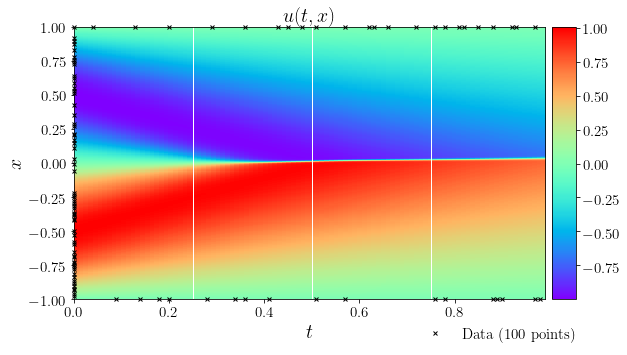

In [11]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

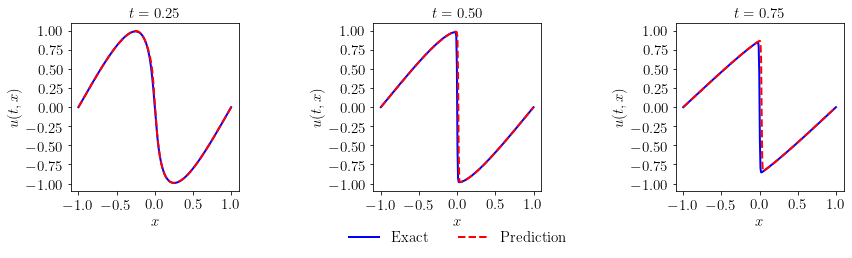

In [12]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()